# Extracting and analyzing rental data from NSW Fair Trading

I will show how to extract, convert and process the rental data available on the NSW Fair Trading website.
The data is available in XLSX. I will extract the data from the XLSX, convert it to a dataframe and then process it to make it usable for analysis.

You can find all the raw data on: https://www.fairtrading.nsw.gov.au/about-fair-trading/rental-bond-data

We will use the following libraries:
- httpx -> Http requests + download
- BeautifulSoup4 -> HTML parsing
- pandas -> Dataframe
- openpyxl -> XLSX reader for pandas

Everything can be installed with pip:

```bash
pip install httpx beautifulsoup4 pandas openpyxl matplotlib
```

In [1]:
# The base imports
from glob import glob

# http client
import httpx
# for HTML parsing
import bs4
# for dataframes
import pandas as pd
# Graph
import matplotlib.pyplot as plt
import os

base_url = "https://www.fairtrading.nsw.gov.au/about-fair-trading/rental-bond-data"

The plan is to:
- Grab the webpage
- Extract the links to the XLSX files
- Download the XLSX files
- Convert the XLSX files to CSV
- Process the CSV files to make them usable for analysis

In [2]:
# Grab the webpage
response = httpx.get(base_url)
# Pass the response to BeautifulSoup
soup = bs4.BeautifulSoup(response.text, "html.parser")

# 2. Parse the HTML table with id #table76559 this table contains all the links to the XLSX files
# this seems to be stable enough
table = soup.find(id="table76559")

# Get all the `a` tags in the first column of the table
# The first column contains the links to the XLSX files
# get all the `tr` tags
hrefs = []
rows = table.find_all("tr")
for row in rows:
    # get the first `td` tag from each `tr` tag with xpath
    first_column = row.find("td")
    if not first_column:
        continue

    # get the first `a` tag from each `td` tag
    first_link = first_column.find("a")
    if not first_link:
        continue

    # get the href attribute from each a tag
    href = first_link.get("href")
    hrefs.append(href)


At this point, we have a list of links to the XLSX files. We can now download them and convert them to CSV.

We will store then in the data folder.

There is a check to prevent downloading the files already downloaded and converted.

In [3]:
# create the directories
os.makedirs("data/xlsx", exist_ok=True)
os.makedirs("data/csv", exist_ok=True)

We can start to download the files.

We will use the httpx library to download the files. We will use the filename from the href to save the files.

In [4]:
# download the files
for href in hrefs:
    # get the filename from the href
    filename = href.split("/")[-1]

    # skip the files already downloaded
    if os.path.exists(f"data/xlsx/{filename}"):
        continue

    # download the file
    response = httpx.get(href)
    # save the file
    with open(f"data/xlsx/{filename}", "wb") as f:
        f.write(response.content)

Now that we have the files, we can convert them to CSV.

We check that the headers are all matching to prevent a problem while importing and joining the dataframes.

In [5]:
# convert the files to CSV
for filename in glob("data/xlsx/*.xlsx"):
    # get the filename without the extension
    filename = filename.split("/")[-1].split(".")[0]
    # skip the files already converted
    if os.path.exists(f"data/csv/{filename}.csv"):
        continue

    # read the file, remove the first 2 rows they are the header from NSW
    df = pd.read_excel(f"data/xlsx/{filename}.xlsx", skiprows=2)
    # save the file
    df.to_csv(f"data/csv/{filename}.csv", index=False)

# check CSV header are all matching
ref_columns = None
for filename in glob("data/csv/*.csv"):
    df = pd.read_csv(filename)
    if ref_columns is None:
        ref_columns = df.columns
        continue
    # Check if the columns match
    if not ref_columns.equals(df.columns):
        print(f"Columns are not matching for {filename}")
        print(ref_columns)

print(ref_columns)
    # print(df.columns)

Index(['Lodgement Date', 'Postcode', 'Dwelling Type', 'Bedrooms',
       'Weekly Rent'],
      dtype='object')


We can now process the CSV files to make them usable for analysis.

Because the CSV are split by month, we will need to concatenate them.

We will:
- Create an empty list to store the dataframes
- Process only the month by month files
- concatenate the dataframes

Notes:
- For the `Dwelling Type` this column is a category. The definition is in the xlsx:
  - F: Flat/unit
  - H House
  - T Terrace/townhouse/semi-detached
  - O Other
  - U Unknown. Dwelling Type of ‘Other’ may include rented rooms, garages and car spaces.
- For the `Bedrooms` a 0 may indicate a bedsitter or studio apartment, or rented premises such as a garage or car space.


In [6]:
dfs = []
# process the CSV files
for filename in glob("data/csv/*.csv"):
    # get the filename without the extension
    filename = filename.split("/")[-1].split(".")[0]
    # If the filename is not month by month, skip it
    # these files contain the work "-year-"
    if "-year-" in filename.lower():
        continue

    # read the file, treat postcodes as string and parse the dates
    df = pd.read_csv(f"data/csv/{filename}.csv", parse_dates=["Lodgement Date"], dtype={"Postcode": str, })
    dfs.append(df)

# concatenate the dataframes
df = pd.concat(dfs)
# convert rent to numeric
df["Weekly Rent"] = pd.to_numeric(df["Weekly Rent"], errors="coerce")
# Save the raw data
# save to csv
df.to_csv("data/rentals.csv", index=False)

In [7]:
# Examine the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1819746 entries, 0 to 32130
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Lodgement Date  datetime64[ns]
 1   Postcode        object        
 2   Dwelling Type   object        
 3   Bedrooms        object        
 4   Weekly Rent     float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 83.3+ MB


We now have a dataframe with 3M+ lines containing all the data. We can start to explore the stats

In [8]:
# Print the first 5 records of the data frame
df.head(5)

,Lodgement Date,Postcode,Dwelling Type,Bedrooms,Weekly Rent
0,2020-10-20,2000,F,0,475.0
1,2020-10-31,2000,F,0,420.0
2,2020-10-29,2000,F,0,410.0
3,2020-10-28,2000,F,0,300.0
4,2020-10-06,2000,F,0,340.0


We now have a dataset of 3M lines. We can start to explore the data.

In [9]:
# do a bit of data cleanup

# only keep flats / houses / townhouses for the moment
df = df[df["Dwelling Type"].isin(["F", "H", "T"])]
# Remove the unknown bedrooms (garage / car space)
df = df[df["Bedrooms"] != '0']
# Remove the unknown bedrooms (garage / car space)
df = df[df["Bedrooms"] != 'U']
# cast the bedrooms to numeric
df["Bedrooms"] = pd.to_numeric(df["Bedrooms"])


I will take a look at the bedroom variable

Bedrooms
2     645948
3     431010
1     310214
4     196660
5      33238
6       4239
7        801
8        169
9         65
10        34
12        26
11        20
22        19
13        15
23        12
21        11
14        10
20         8
25         7
15         6
17         4
24         4
27         4
16         4
26         4
30         2
18         2
29         2
Name: count, dtype: int64


<Axes: xlabel='Bedrooms'>

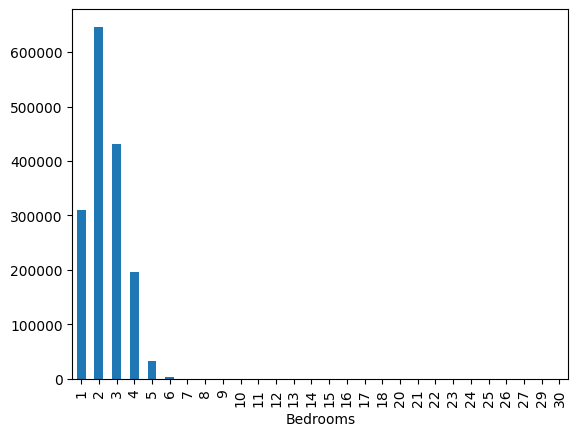

In [10]:
# Count the number of bedrooms
count_of_bedrooms = df["Bedrooms"].value_counts()
print(count_of_bedrooms)
# sort by number of rooms
count_of_bedrooms = count_of_bedrooms.sort_index()
# graph the number of bedrooms
count_of_bedrooms.plot(kind="bar")

It seems you can rent a 30-bedroom dwelling in NSW.
Also, there are more 2 and 3 bedroom dwellings than 1 bedroom.

We should note that a rental can be rented multiple times. We don't have the individual rental history, so I can't see if tenant of 1 bedroom stays for longer than 2 bedrooms, which would explain the difference.

<Axes: xlabel='Lodgement Date'>

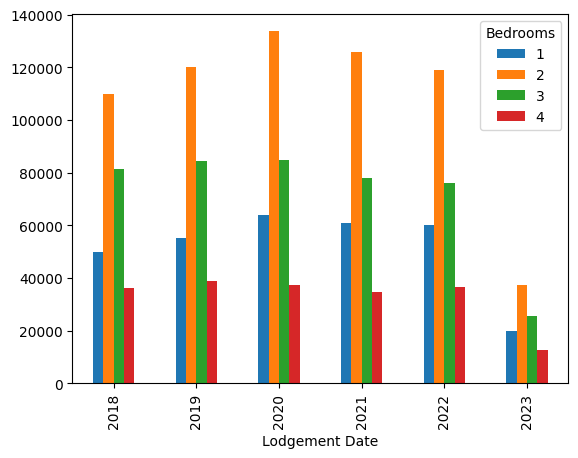

In [11]:
# count the number of bedrooms per year
# remove the 5+ bedrooms from the dataframe to allow the graph to be readable
df_bedrooms_year = df[df["Bedrooms"] < 5]

df_bedrooms_year = df_bedrooms_year.groupby(df_bedrooms_year["Lodgement Date"].dt.to_period("Y"))["Bedrooms"].value_counts()
# plot the number of bedrooms per year
df_bedrooms_year.unstack().plot(kind="bar", stacked=False)

<Axes: xlabel='Lodgement Date'>

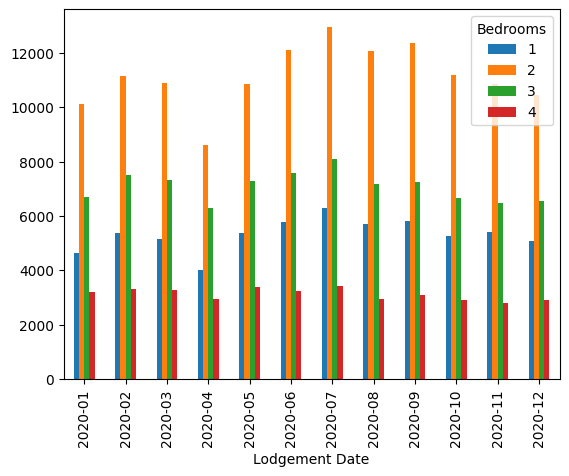

In [12]:
# taking a look at the COVID-19 period, I only select 2020 with less than 5 bedrooms and group by month
df_bedrooms_covid = df[(df["Bedrooms"] < 5) & (df["Lodgement Date"].dt.year == 2020)]
df_bedrooms_covid = df_bedrooms_covid.groupby(df_bedrooms_covid["Lodgement Date"].dt.to_period("M"))["Bedrooms"].value_counts()
# plot the number of bedrooms per month
df_bedrooms_covid.unstack().plot(kind="bar", stacked=False)

In [13]:
# group by year and month and calculate the mean rent by month
df_monthly = df.groupby(df["Lodgement Date"].dt.to_period("M"))

In [14]:
# print the top 10
df_monthly["Weekly Rent"].mean().sort_values(ascending=False).head(10)

Lodgement Date
2023-04    667.869122
2023-02    667.852278
2023-03    664.524542
2023-01    648.031618
2022-11    633.941006
2022-12    630.425073
2022-10    625.486096
2022-09    616.666747
2022-08    612.790923
2022-07    602.088346
Freq: M, Name: Weekly Rent, dtype: float64

In [15]:
df_monthly["Weekly Rent"].mean().sort_values(ascending=False).tail(10)

Lodgement Date
2018-12    524.555816
2020-10    523.267922
2020-09    523.158242
2020-11    522.372004
2020-12    521.910451
2020-06    520.928513
2020-07    520.603332
2020-08    519.454173
2020-04    509.721756
2020-05    509.090939
Freq: M, Name: Weekly Rent, dtype: float64

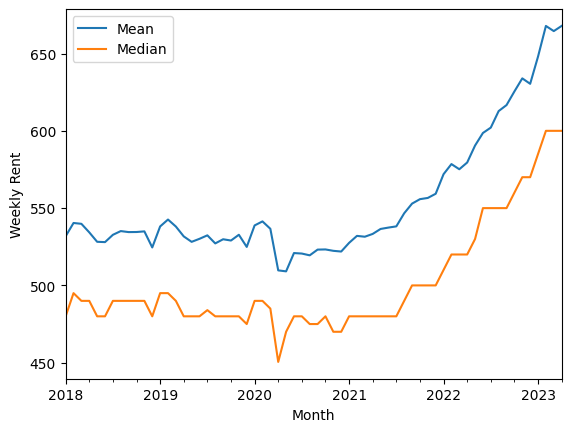

In [16]:
# plot the mean and the median rent by month
df_monthly["Weekly Rent"].mean().plot(label="Mean")
df_monthly["Weekly Rent"].median().plot(label="Median")
# add the labels
plt.xlabel("Month")
plt.ylabel("Weekly Rent")
plt.legend()


<Axes: xlabel='Lodgement Date'>

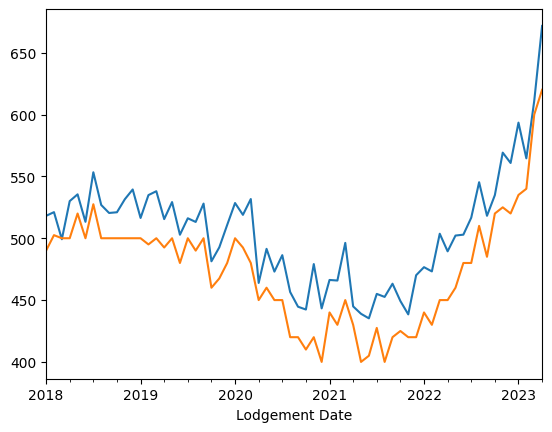

In [17]:
# compute for ashfield, postcode 2131
df_ashfield = df[df["Postcode"] == "2131"]


df_ashfield_monthly = df_ashfield.groupby(df_ashfield["Lodgement Date"].dt.to_period("M"))
df_ashfield_monthly["Weekly Rent"].mean().plot()
# do the median
df_ashfield_monthly["Weekly Rent"].median().plot()

In [18]:
df_ashfield

,Lodgement Date,Postcode,Dwelling Type,Bedrooms,Weekly Rent
11343,2020-10-16,2131,F,1,495.0
11344,2020-10-14,2131,F,1,300.0
11345,2020-10-20,2131,F,1,350.0
11346,2020-10-19,2131,F,1,350.0
11347,2020-10-15,2131,F,1,400.0
...,...,...,...,...,...
12416,2020-09-23,2131,H,4,900.0
12420,2020-09-11,2131,T,2,550.0
12421,2020-09-25,2131,T,2,350.0
12422,2020-09-26,2131,T,2,450.0


<Axes: xlabel='Lodgement Date'>

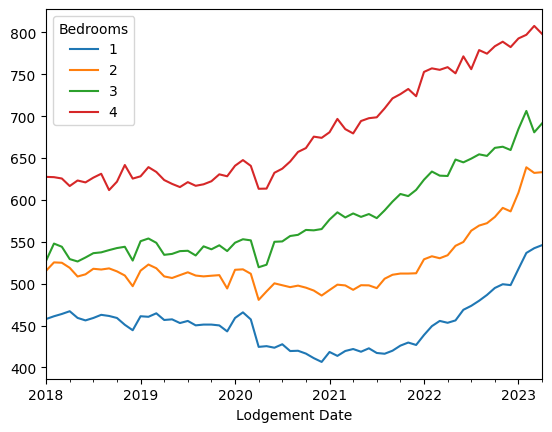

In [19]:
# select with 1, 2 or 3, 4 bedrooms for df_monthly
df_bedrooms = df[df["Bedrooms"] < 5]
# group by year month and bedrooms and calculate the mean rent
df_monthly_1 = df_bedrooms.groupby([df_bedrooms["Lodgement Date"].dt.to_period("M"), "Bedrooms"])
# plot the mean rent
df_monthly_1["Weekly Rent"].mean().unstack().plot()

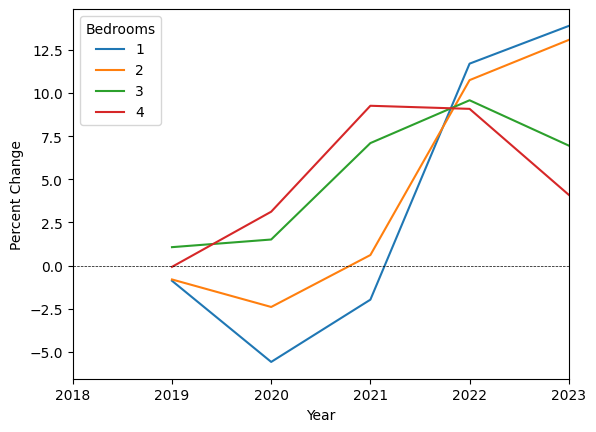

In [25]:
# group by year and bedrooms and calculate the percent change of the mean rent
df_monthly_1 = df_bedrooms.groupby([df_bedrooms["Lodgement Date"].dt.to_period("Y"), "Bedrooms"])
# Multiply by 100 to get the percentage
pct_change = df_monthly_1["Weekly Rent"].mean().unstack().pct_change()
pct_change = pct_change * 100
pct_change.plot()
# add the labels
plt.xlabel("Year")
plt.ylabel("Percent Change")
# add the horizontal line at 0
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

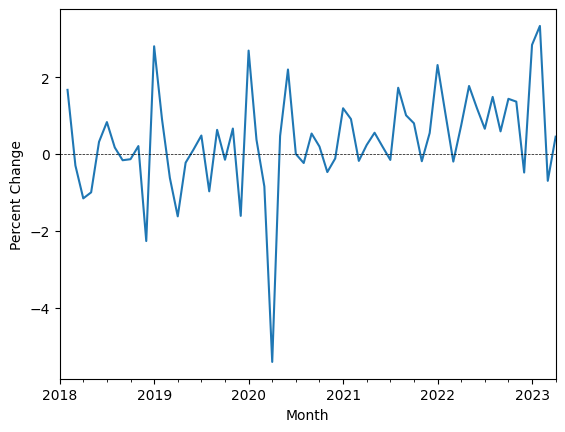

In [26]:
# calculate the percent change per month
df_monthly_df = df_bedrooms.groupby([df_bedrooms["Lodgement Date"].dt.to_period("M")])
pct_change = df_monthly_df["Weekly Rent"].mean().pct_change()
pct_change = pct_change * 100
# plot the percent change
pct_change.plot()
# add the labels
plt.xlabel("Month")
plt.ylabel("Percent Change")
# add the horizontal line at 0
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)